# Optimization Methods

I basically followed https://github.com/Kulbear 's work on Andrew Ng's Deep Learning Specialization C2W2 homework assignment with some modification

## 1. Importing the libraries and setting up enviornment

In [1]:
# importing public libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.io 
import math
import sklearn
import sklearn.datasets

import sys
from google.colab import drive

In [2]:
# mounting google drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/Deep Learning Specialization/02 Improving Deep Neural Networks Hyperparameter tuning, Regularization and Optimization/C2W2')

from opt_utils import load_params_and_grads, initialize_parameters, forward_propagation, backward_propagation
from opt_utils import compute_cost, predict, predict_dec, plot_decision_boundary, load_dataset
from testCases import *

## 2. Gradient Descent

In [4]:
def update_parameters_with_gd(parameters, grads, learning_rate):
  """
  Update parameters using one step of gradient descent

  Arguments:
  parameters -- python dictionary containing your parameters to be updated:
                  parameters['W' + str(l)] = Wl
                  parameters['b' + str(l)] = bl
  grads -- python dictionary containing your gradients to update each parameters:
                  grads['dW' + str(l)] = dWl
                  grads['db' + str(l)] = dbl
  learning_rate -- the learning rate, scalar.

  Returns:
  parameters -- python dictionary containing your updated parameters 
  """

  L = len(parameters) // 2
  
  for l in range (1, L+1, 1):
    W = parameters['W' + str(l)]
    b  = parameters['b' + str(l)]
    dw = grads['dW' + str(l)]
    db = grads['db'+ str(l)]
    parameters['W' + str(l)] = W - learning_rate * dw
    parameters['b' + str(l)] = b - learning_rate * db   
  return parameters


In [5]:
parameters, grads, learning_rate = update_parameters_with_gd_test_case()

parameters = update_parameters_with_gd(parameters, grads, learning_rate)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 1.63535156 -0.62320365 -0.53718766]
 [-1.07799357  0.85639907 -2.29470142]]
b1 = [[ 1.74604067]
 [-0.75184921]]
W2 = [[ 0.32171798 -0.25467393  1.46902454]
 [-2.05617317 -0.31554548 -0.3756023 ]
 [ 1.1404819  -1.09976462 -0.1612551 ]]
b2 = [[-0.88020257]
 [ 0.02561572]
 [ 0.57539477]]


##2. Mini-Batch Gradient Descent

In [6]:
# !np.random.permutation? show documentation

In [12]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
  """
  Creates a list of random minibatches from (X, Y)

  Arguments:
  X -- input data, of shape (input size, number of examples)
  Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
  mini_batch_size -- size of the mini-batches, integer

  Returns:
  mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
  """
  #import sklearn.utils 
  #X, y = sklearn.utils.shuffle(X, Y)
  np.random.seed(seed)  
  m = X.shape[1]
  mini_batches = []

  #1. shuffle X, Y
  permutation = np.random.permutation(m).tolist()
  X_shuffled = X[:, permutation]
  Y_shuffled = Y[:, permutation]

  num_complete_minibatches =   m //  mini_batch_size 

  #2. Partition
  for k in range(0, num_complete_minibatches, 1):
    mini_batch_X = X_shuffled[ :, k * mini_batch_size : (k+1) * mini_batch_size]
    mini_batch_Y = Y_shuffled[ :, k * mini_batch_size : (k+1) * mini_batch_size]
    mini_batches.append((mini_batch_X,mini_batch_Y ))

  if m % mini_batch_size  != 0:
    mini_batch_X = X_shuffled[ :  ,  num_complete_minibatches * mini_batch_size : ]
    mini_batch_Y = Y_shuffled[ :  ,  num_complete_minibatches * mini_batch_size : ]
    mini_batches.append((mini_batch_X,mini_batch_Y ))

  # actually, we can use the following code instead
  # numpy slicing ignore non-existing index without throw exception
  # for k in range(0, m, mini_batch_size):
  #   mini_batch_X = X_shuffled[ :, k: k+ mini_batch_size]
  #   mini_batch_Y = Y_shuffled[ :, k: k+ mini_batch_size]
  #   print('current_batch_size=', mini_batch_X.shape[1])
  #   mini_batches.append((mini_batch_X,mini_batch_Y ))
  return mini_batches


In [13]:
X_assess, Y_assess, mini_batch_size = random_mini_batches_test_case()
mini_batches = random_mini_batches(X_assess, Y_assess, mini_batch_size)

print ("shape of the 1st mini_batch_X: " + str(mini_batches[0][0].shape))
print ("shape of the 2nd mini_batch_X: " + str(mini_batches[1][0].shape))
print ("shape of the 3rd mini_batch_X: " + str(mini_batches[2][0].shape))
print ("shape of the 1st mini_batch_Y: " + str(mini_batches[0][1].shape))
print ("shape of the 2nd mini_batch_Y: " + str(mini_batches[1][1].shape)) 
print ("shape of the 3rd mini_batch_Y: " + str(mini_batches[2][1].shape))
print ("mini batch sanity check: " + str(mini_batches[0][0][0][0:3]))

shape of the 1st mini_batch_X: (12288, 64)
shape of the 2nd mini_batch_X: (12288, 64)
shape of the 3rd mini_batch_X: (12288, 20)
shape of the 1st mini_batch_Y: (1, 64)
shape of the 2nd mini_batch_Y: (1, 64)
shape of the 3rd mini_batch_Y: (1, 20)
mini batch sanity check: [ 0.90085595 -0.7612069   0.2344157 ]


## 4. Gradient Descent with Momentum

In [16]:
def initialize_velocity(parameters):
  """
  Initializes the velocity as a python dictionary with:
              - keys: "dW1", "db1", ..., "dWL", "dbL" 
              - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
  Arguments:
  parameters -- python dictionary containing your parameters.
                  parameters['W' + str(l)] = Wl
                  parameters['b' + str(l)] = bl

  Returns:
  v -- python dictionary containing the current velocity.
                  v['dW' + str(l)] = velocity of dWl
                  v['db' + str(l)] = velocity of dbl
  """
  L = len(parameters) // 2
  v = {}

  for l in range (1, L+1, 1):
    W = parameters['W' + str(l)]
    b = parameters['b' + str(l)]
    v['dW' + str(l)] = np.zeros(W.shape)
    v['db' + str(l)] = np.zeros(b.shape)
  
  return v


In [17]:
parameters = initialize_velocity_test_case()

v = initialize_velocity(parameters)
print("v[\"dW1\"] = " + str(v["dW1"]))
print("v[\"db1\"] = " + str(v["db1"]))
print("v[\"dW2\"] = " + str(v["dW2"]))
print("v[\"db2\"] = " + str(v["db2"]))

v["dW1"] = [[0. 0. 0.]
 [0. 0. 0.]]
v["db1"] = [[0.]
 [0.]]
v["dW2"] = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v["db2"] = [[0.]
 [0.]
 [0.]]


In [24]:
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
  """
  Update parameters using Momentum

  Arguments:
  parameters -- python dictionary containing your parameters:
                  parameters['W' + str(l)] = Wl
                  parameters['b' + str(l)] = bl
  grads -- python dictionary containing your gradients for each parameters:
                  grads['dW' + str(l)] = dWl
                  grads['db' + str(l)] = dbl
  v -- python dictionary containing the current velocity:
                  v['dW' + str(l)] = ...
                  v['db' + str(l)] = ...
  beta -- the momentum hyperparameter, scalar
  learning_rate -- the learning rate, scalar

  Returns:
  parameters -- python dictionary containing your updated parameters 
  v -- python dictionary containing your updated velocities
  """

  L = len(parameters) // 2


  for l in range(1, L+1, 1):
    W = parameters['W' + str(l)] 
    b = parameters['b' + str(l)] 
    dW = grads['dW' + str(l)] 
    db = grads['db' + str(l)]    

    # calculate momentum 
    v['dW' + str(l)] = beta *  v['dW' + str( l )] + (1-beta) * grads['dW' + str(l)]
    v['db' + str(l)]  = beta *  v['db' + str( l )]  + (1-beta) * grads['db' + str(l)]
    # update parameter
    parameters['W' + str(l)]  = parameters['W' + str(l)]  - learning_rate *  v['dW' + str(l)]
    parameters['b' + str(l)]  = parameters['b' + str(l)] - learning_rate *  v['db' + str(l)]
  return parameters, v

In [25]:
parameters, grads, v = update_parameters_with_momentum_test_case()

parameters, v = update_parameters_with_momentum(parameters, grads, v, beta = 0.9, learning_rate = 0.01)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
print("v[\"dW1\"] = " + str(v["dW1"]))
print("v[\"db1\"] = " + str(v["db1"]))
print("v[\"dW2\"] = " + str(v["dW2"]))
print("v[\"db2\"] = " + str(v["db2"]))

W1 = [[ 1.62544598 -0.61290114 -0.52907334]
 [-1.07347112  0.86450677 -2.30085497]]
b1 = [[ 1.74493465]
 [-0.76027113]]
W2 = [[ 0.31930698 -0.24990073  1.4627996 ]
 [-2.05974396 -0.32173003 -0.38320915]
 [ 1.13444069 -1.0998786  -0.1713109 ]]
b2 = [[-0.87809283]
 [ 0.04055394]
 [ 0.58207317]]
v["dW1"] = [[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = [[-0.01228902]
 [-0.09357694]]
v["dW2"] = [[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = [[0.02344157]
 [0.16598022]
 [0.07420442]]


##5. Adam

In [26]:
def initialize_adam(parameters) :
  """
  Initializes v and s as two python dictionaries with:
              - keys: "dW1", "db1", ..., "dWL", "dbL" 
              - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
  
  Arguments:
  parameters -- python dictionary containing your parameters.
                  parameters["W" + str(l)] = Wl
                  parameters["b" + str(l)] = bl
  
  Returns: 
  v -- python dictionary that will contain the exponentially weighted average of the gradient.
                  v["dW" + str(l)] = ...
                  v["db" + str(l)] = ...
  s -- python dictionary that will contain the exponentially weighted average of the squared gradient.
                  s["dW" + str(l)] = ...
                  s["db" + str(l)] = ...

  """

  v, s = {}, {}

  L =  len(parameters) // 2

  for l in range (1, L+1, 1):
    v['dW' + str(l)] = np.zeros(parameters['W'+ str(l)].shape )
    v['db' + str(l)] = np.zeros(parameters['b'+ str(l)].shape )
    s['dW' + str(l)] = np.zeros(parameters['W'+ str(l)].shape )
    s['db' + str(l)] = np.zeros(parameters['b'+ str(l)].shape )

  return v, s

In [27]:
parameters = initialize_adam_test_case()

v, s = initialize_adam(parameters)
print("v[\"dW1\"] = " + str(v["dW1"]))
print("v[\"db1\"] = " + str(v["db1"]))
print("v[\"dW2\"] = " + str(v["dW2"]))
print("v[\"db2\"] = " + str(v["db2"]))
print("s[\"dW1\"] = " + str(s["dW1"]))
print("s[\"db1\"] = " + str(s["db1"]))
print("s[\"dW2\"] = " + str(s["dW2"]))
print("s[\"db2\"] = " + str(s["db2"]))

v["dW1"] = [[0. 0. 0.]
 [0. 0. 0.]]
v["db1"] = [[0.]
 [0.]]
v["dW2"] = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v["db2"] = [[0.]
 [0.]
 [0.]]
s["dW1"] = [[0. 0. 0.]
 [0. 0. 0.]]
s["db1"] = [[0.]
 [0.]]
s["dW2"] = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
s["db2"] = [[0.]
 [0.]
 [0.]]


In [36]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate=0.01,
                                beta1=0.9, beta2=0.999, epsilon=1e-8):
  """
  Update parameters using Adam

  Arguments:
  parameters -- python dictionary containing your parameters:
                  parameters['W' + str(l)] = Wl
                  parameters['b' + str(l)] = bl
  grads -- python dictionary containing your gradients for each parameters:
                  grads['dW' + str(l)] = dWl
                  grads['db' + str(l)] = dbl
  v -- Adam variable, moving average of the first gradient, python dictionary
  s -- Adam variable, moving average of the squared gradient, python dictionary
  learning_rate -- the learning rate, scalar.
  beta1 -- Exponential decay hyperparameter for the first moment estimates 
  beta2 -- Exponential decay hyperparameter for the second moment estimates 
  epsilon -- hyperparameter preventing division by zero in Adam updates

  Returns:
  parameters -- python dictionary containing your updated parameters 
  v -- Adam variable, moving average of the first gradient, python dictionary
  s -- Adam variable, moving average of the squared gradient, python dictionary
  """

  L = len(parameters) // 2
  v_corrected = {}                         # Initializing first moment estimate, python dictionary
  s_corrected = {}    

  for l in range (1, L+1, 1):
    # calculate moving average of first momentum and  moving average of second momentum
    v['dW'+str(l)]  = beta1 * v['dW'+str(l)]  + (1-beta1) * grads['dW'+str(l)]
    v['db'+str(l)]  = beta1 * v['db'+str(l)]  + (1-beta1) * grads['db'+str(l)]
    v_corrected ['dW'+str(l)]= v ['dW'+str(l)] / (1 - np.power(beta1, t))
    v_corrected ['db'+str(l)]= v ['db'+str(l)] / (1 - np.power(beta1, t))

    s['dW'+str(l)]  = beta2 * s['dW'+str(l)]  + (1-beta2) * np.power( grads['dW'+str(l)], 2)
    s['db'+str(l)]  = beta2 * s['db'+str(l)]  + (1-beta2) *  np.power( grads['db'+str(l)], 2)
    s_corrected ['dW'+str(l)]= s ['dW'+str(l)] / (1 - np.power(beta2, t))
    s_corrected ['db'+str(l)]= s ['db'+str(l)] / (1 - np.power(beta2, t))

    parameters['W'+str(l)] = parameters['W'+str(l)]  - learning_rate * v_corrected ['dW'+str(l)]  / np.sqrt(s_corrected ['dW'+str(l)]+epsilon)
    parameters['b'+str(l)] = parameters['b'+str(l)]  - learning_rate * v_corrected ['db'+str(l)]  / np.sqrt(s_corrected ['db'+str(l)]+epsilon)

  return  parameters, v, s

In [37]:
parameters, grads, v, s = update_parameters_with_adam_test_case()
parameters, v, s  = update_parameters_with_adam(parameters, grads, v, s, t = 2)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
print("v[\"dW1\"] = " + str(v["dW1"]))
print("v[\"db1\"] = " + str(v["db1"]))
print("v[\"dW2\"] = " + str(v["dW2"]))
print("v[\"db2\"] = " + str(v["db2"]))
print("s[\"dW1\"] = " + str(s["dW1"]))
print("s[\"db1\"] = " + str(s["db1"]))
print("s[\"dW2\"] = " + str(s["dW2"]))
print("s[\"db2\"] = " + str(s["db2"]))

W1 = [[ 1.63178673 -0.61919778 -0.53561312]
 [-1.08040999  0.85796626 -2.29409733]]
b1 = [[ 1.75225313]
 [-0.75376553]]
W2 = [[ 0.32648046 -0.25681174  1.46954931]
 [-2.05269934 -0.31497584 -0.37661299]
 [ 1.14121081 -1.09245036 -0.16498684]]
b2 = [[-0.88529978]
 [ 0.03477238]
 [ 0.57537385]]
v["dW1"] = [[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = [[-0.01228902]
 [-0.09357694]]
v["dW2"] = [[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = [[0.02344157]
 [0.16598022]
 [0.07420442]]
s["dW1"] = [[0.00121136 0.00131039 0.00081287]
 [0.0002525  0.00081154 0.00046748]]
s["db1"] = [[1.51020075e-05]
 [8.75664434e-04]]
s["dW2"] = [[7.17640232e-05 2.81276921e-04 4.78394595e-04]
 [1.57413361e-04 4.72206320e-04 7.14372576e-04]
 [4.50571368e-04 1.60392066e-07 1.24838242e-03]]
s["db2"] = [[5.49507194e-05]
 [2.75494327e-03]
 [5.50629536e-04]]


6. Model with different optimization algorithms

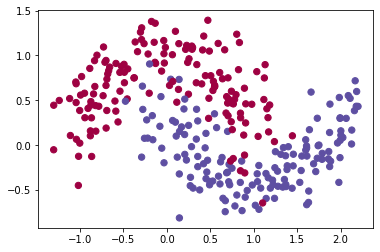

In [38]:
train_X, train_Y = load_dataset()

In [39]:
def model(X, Y, layers_dims, optimizer, learning_rate=0.0007, mini_batch_size=64, beta=0.9,
          beta1=0.9, beta2=0.999, epsilon=1e-8, num_epochs=10000, print_cost=True):
    """
    3-layer neural network model which can be run in different optimizer modes.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)

        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            a3, caches = forward_propagation(minibatch_X, parameters)

            # Compute cost
            cost = compute_cost(a3, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        
        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print("Cost after epoch %i: %f" % (i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

Cost after epoch 0: 0.690736
Cost after epoch 1000: 0.685273
Cost after epoch 2000: 0.647072
Cost after epoch 3000: 0.619525
Cost after epoch 4000: 0.576584
Cost after epoch 5000: 0.607243
Cost after epoch 6000: 0.529403
Cost after epoch 7000: 0.460768
Cost after epoch 8000: 0.465586
Cost after epoch 9000: 0.464518


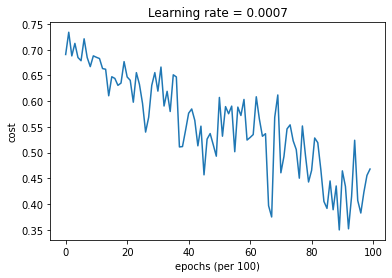

Accuracy: 0.7966666666666666


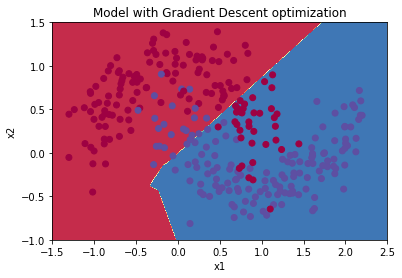

In [40]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer="gd")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)


Cost after epoch 0: 0.690741
Cost after epoch 1000: 0.685341
Cost after epoch 2000: 0.647145
Cost after epoch 3000: 0.619594
Cost after epoch 4000: 0.576665
Cost after epoch 5000: 0.607324
Cost after epoch 6000: 0.529476
Cost after epoch 7000: 0.460936
Cost after epoch 8000: 0.465780
Cost after epoch 9000: 0.464740


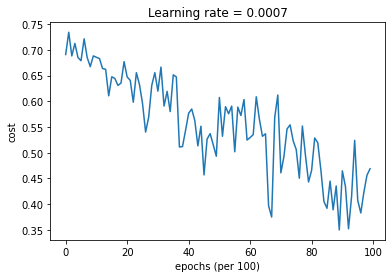

Accuracy: 0.7966666666666666


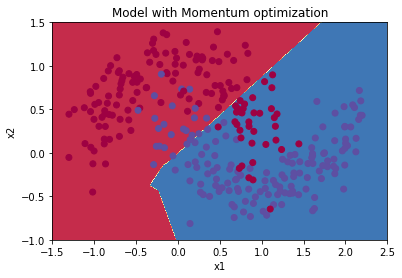

In [41]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta=0.9, optimizer="momentum")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Cost after epoch 0: 0.690552
Cost after epoch 1000: 0.185501
Cost after epoch 2000: 0.150830
Cost after epoch 3000: 0.074454
Cost after epoch 4000: 0.125959
Cost after epoch 5000: 0.104344
Cost after epoch 6000: 0.100676
Cost after epoch 7000: 0.031652
Cost after epoch 8000: 0.111973
Cost after epoch 9000: 0.197940


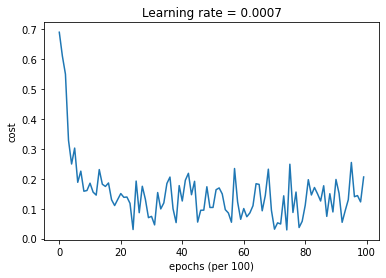

Accuracy: 0.94


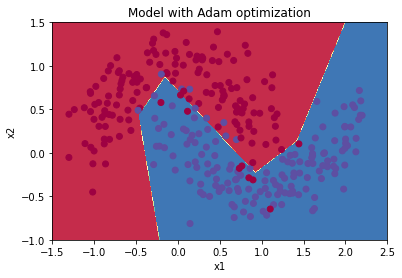

In [42]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer="adam")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)
